In [1]:
import numpy as np
import time
from PySDM import Formulae
from PySDM.physics.constants import si
from PySDM.backends import CPU
from PySDM_examples.Luettmer_homogeneous_freezing.simulation import Simulation
from PySDM_examples.Luettmer_homogeneous_freezing.settings import Settings
from PySDM_examples.Luettmer_homogeneous_freezing import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot


In [10]:
"""  basic setup for homogeneous freezing of pure-liquid droplets """

formulae = Formulae(
    particle_shape_and_density="MixedPhaseSpheres",
)

def run_simulations(setting):

        simulation = { "settings": setting,
                       "ensemble_member_outputs": [],
                       }
        for n in range(setting["number_of_ensemble_runs"]):
            model_setup = Settings(**simulation["settings"])
            model_setup.formulae.seed += 1
            model = Simulation(model_setup)
            simulation["ensemble_member_outputs"].append( model.run() )

        return simulation

standard = { "n_sd": int(1e4),
    "w_updraft": 1 * si.meter / si.second,
    "T0": formulae.trivia.C2K(-25),
    "dz": 0.5 * si.meter,
    "N_dv_droplet_distribution":  5000 / si.cm**3,
    "r_mean_droplet_distribution": 15 * si.nanometer,
    "type_droplet_distribution": "monodisperse",
    "RH_0": 0.995,
    "p0": 500 * si.hectopascals,
    "condensation_enable": True,
    "deposition_enable": True,
    "deposition_adaptive": True,
    "number_of_ensemble_runs": 1,
            }

backends = {
   "threshold": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Null",
        saturation_vapour_pressure="MurphyKoop2005",
        seed=time.time_ns(),
    )),
    "KoopMurray2016": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="KoopMurray2016",
        saturation_vapour_pressure="MurphyKoop2005",
        seed=time.time_ns(),
    )),
   "Koop_Correction": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Koop_Correction",
        saturation_vapour_pressure="MurphyKoop2005",
        seed=time.time_ns(),
    )),
    "Koop2000": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Koop2000",
        saturation_vapour_pressure="MurphyKoop2005",
        seed=time.time_ns(),
    )),
}

hom_freezing_types =[  "KoopMurray2016", "Koop_Correction", "Koop2000"  ]

vertical_updrafts = np.geomspace(0.2,10,num=10) * si.meter / si.second


Setting up simulation for threshold with wpdraft=10.0 and n_sd=1000 and n_dv=4999999999.999999
0.05 0.5 10.0
Starting simulation...
all particles frozen or evaporated


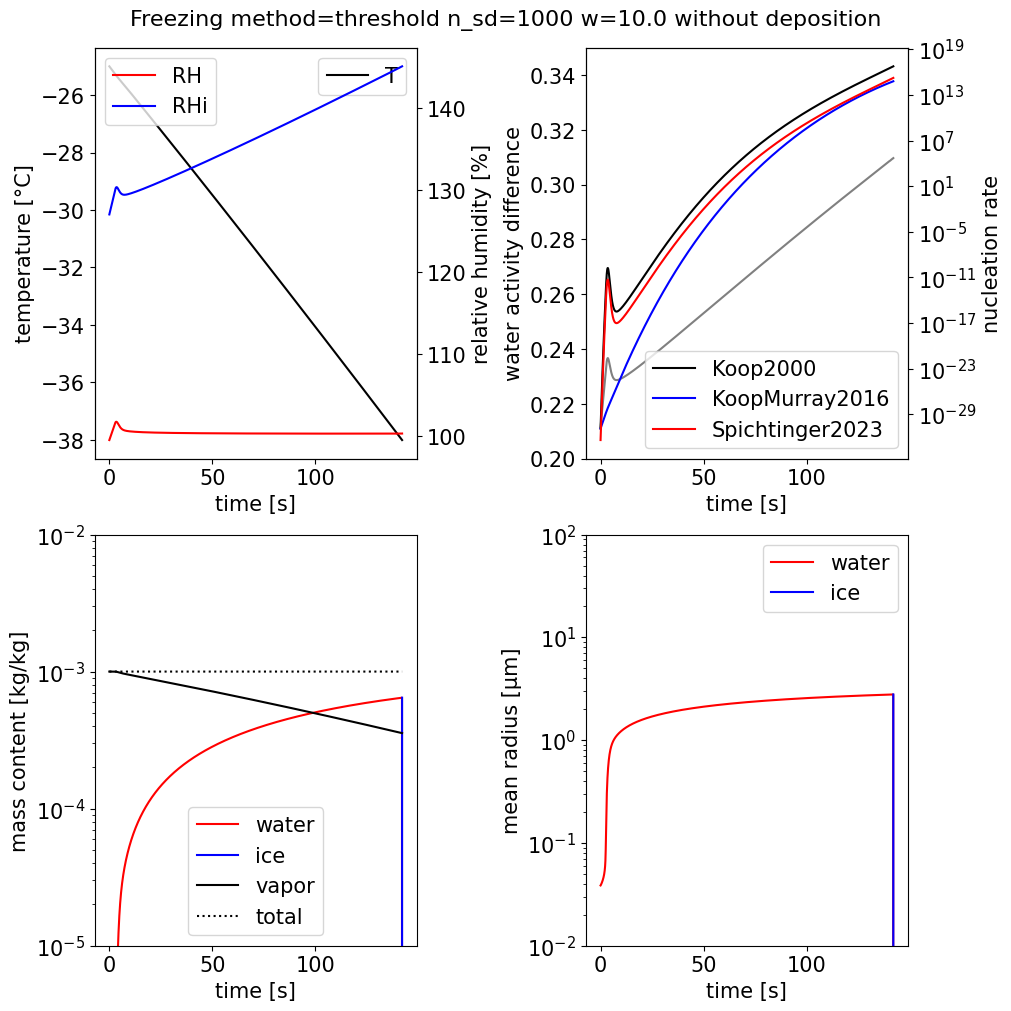

In [8]:
""" Reference simulations for threshold """
setting_dict = {
            **standard,
            "backend": backends["threshold"],
            "hom_freezing": "threshold",
            "w_updraft": vertical_updrafts[-1],
            }
threshold_reference_high_w_simulation = run_simulations(setting_dict)
plot.plot_thermodynamics_and_bulk(threshold_reference_high_w_simulation, " without deposition")

Setting up simulation for threshold with wpdraft=0.1 and n_sd=10000 and n_dv=4999999999.999999
5.0 0.5 0.1
Starting simulation...
all particles frozen or evaporated


/uni-mainz.de/homes/tluettm/python/PySDM/examples/PySDM_examples/Luettmer_homogeneous_freezing/simulation.py:172: UserWarning: Water saturation is too high outside of activation and mixed-phase environment
  warnings.warn( "Water saturation is too high outside of activation and mixed-phase environment" )


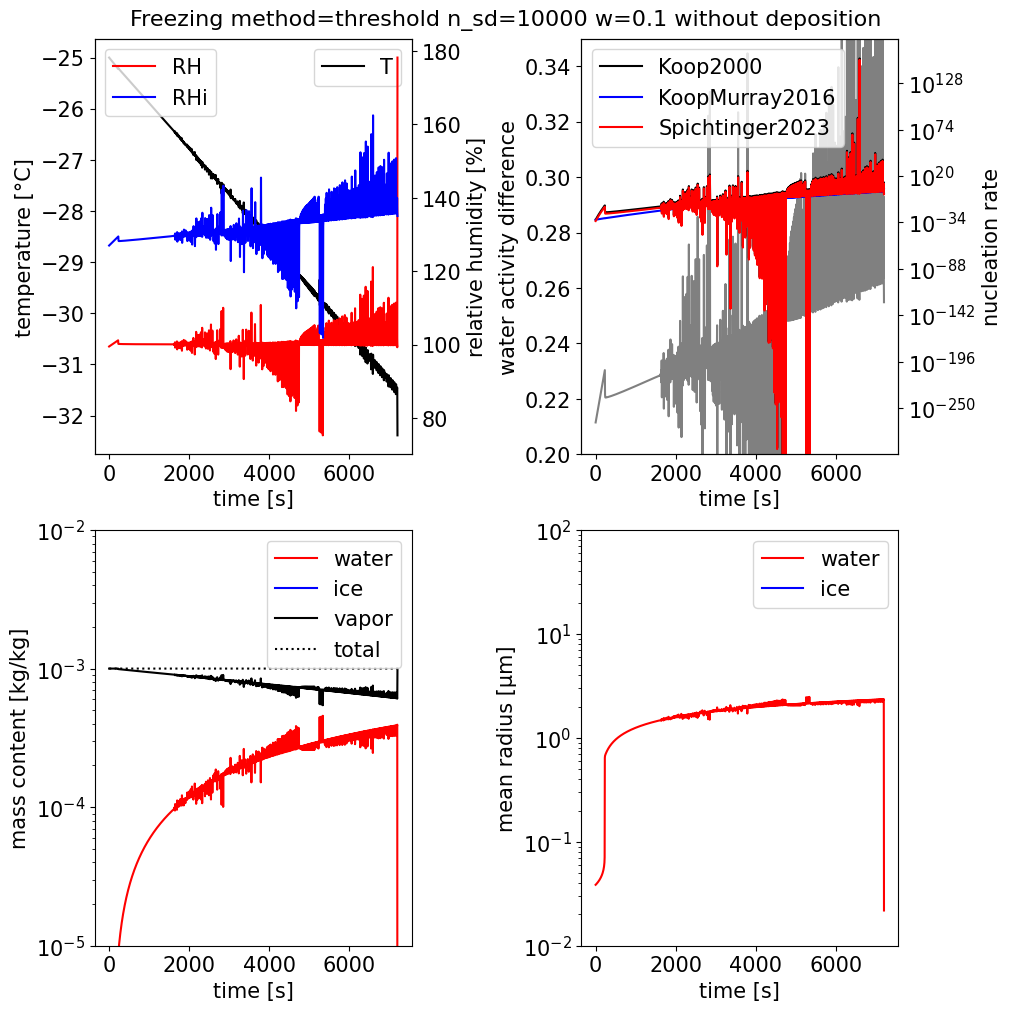

In [11]:
setting_dict = {
            **standard,
            "backend": backends["threshold"],
            "hom_freezing": "threshold",
            "w_updraft": 0.1,
            }
threshold_reference_low_w_simulation = run_simulations(setting_dict)
plot.plot_thermodynamics_and_bulk(threshold_reference_low_w_simulation, " without deposition")

In [ ]:
""" Ensemble simulations without deposition  """
simulations_ensemble_no_deposition = []


for hom_freezing_type in hom_freezing_types:
    for updraft in vertical_updrafts:
        setting_dict = {
            **standard,
            "w_updraft": updraft  * si.meter / si.second,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
            }
        simulations_ensemble_no_deposition.append( run_simulations(setting_dict) )

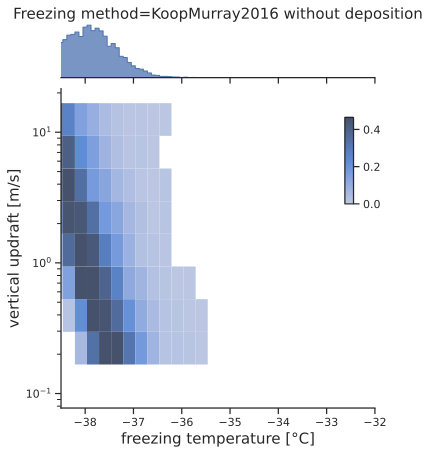

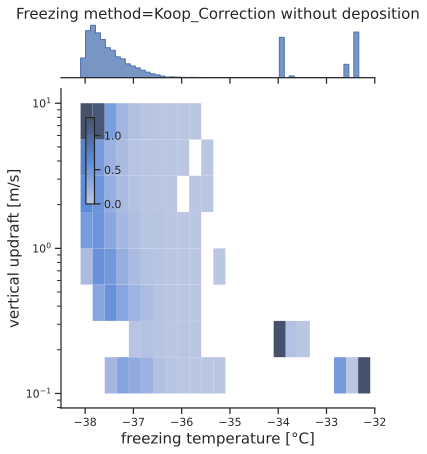

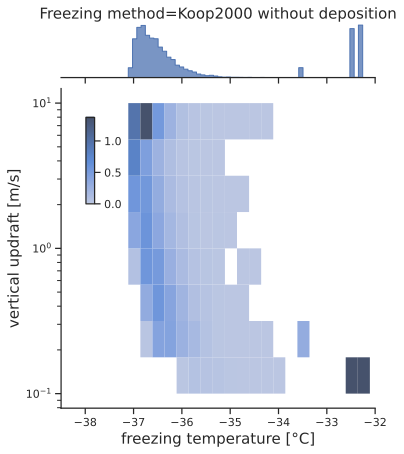

In [11]:
""" Plot ensemble simulations without deposition  """
reload(plot)


for hom_freezing_type in hom_freezing_types:

    histogram_data_dict = {}

    histogram_data_dict["hom_freezing_type"] = hom_freezing_type
    histogram_data_dict["T_frz_histogram_list"] = []
    histogram_data_dict["w_updraft_histogram_list"] = []

    for i, updraft in enumerate(vertical_updrafts):
        for simulation in simulations_ensemble_no_deposition:
            if (simulation["settings"]["w_updraft"] == updraft
                    and simulation["settings"]["hom_freezing"] == hom_freezing_type):
                output = simulation["ensemble_member_outputs"][0]
                T_frz = output["T_frz"][-1]
                histogram_data_dict["T_frz_histogram_list"].extend( T_frz )
                histogram_data_dict["w_updraft_histogram_list"].extend( np.full_like(T_frz, updraft) )

    plot.plot_freezing_temperatures_2d_histogram_seaborn(histogram_data_dict, title_add = " without deposition")
    show_plot()

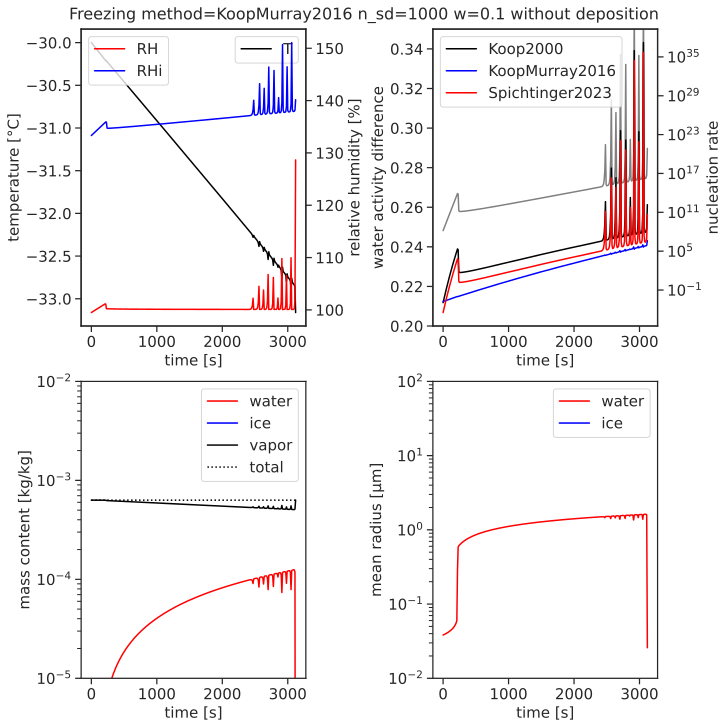

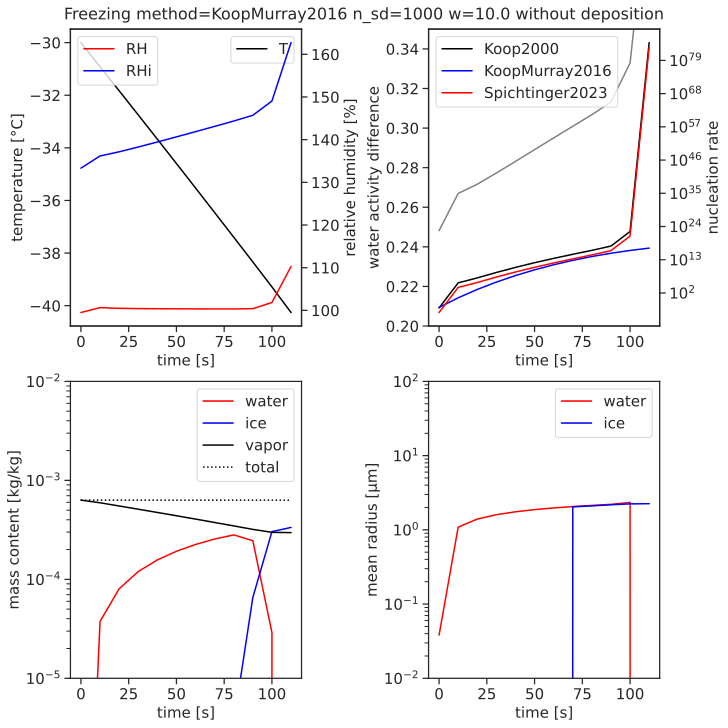

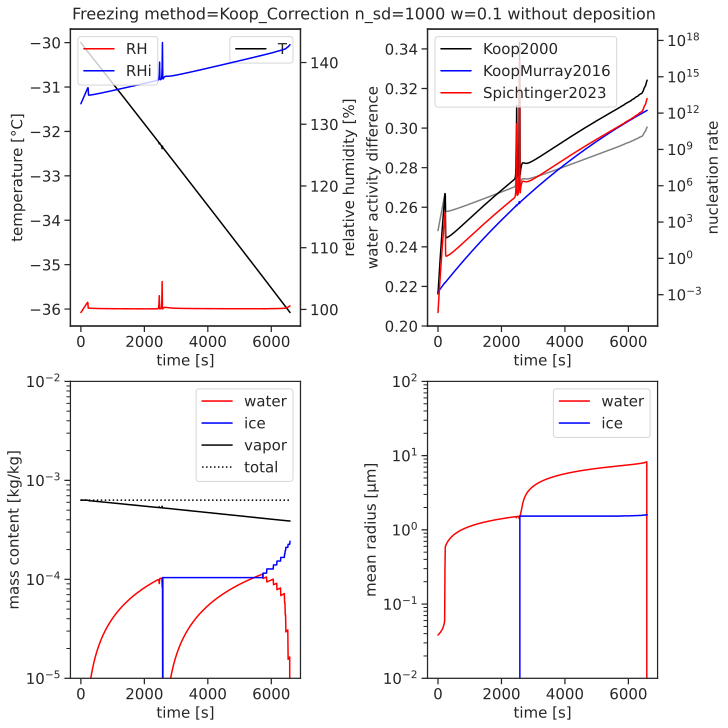

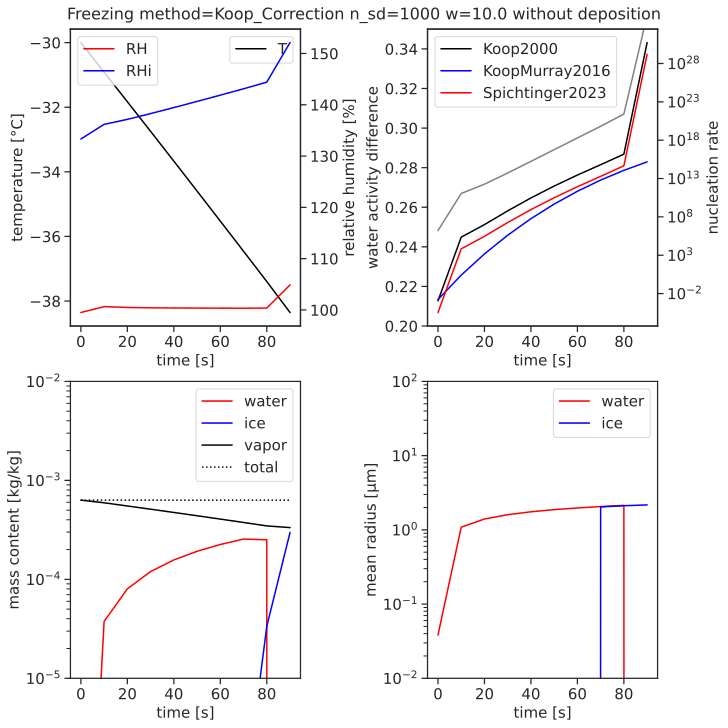

In [12]:
for simulation in simulations_ensemble_no_deposition:
    if simulation["settings"]["w_updraft"] in (vertical_updrafts[0],vertical_updrafts[-1]):

        # if (simulation["settings"]["hom_freezing"] == "KoopMurray2016") or (simulation["settings"]["hom_freezing"] == "Koop_Correction"):
        if simulation["settings"]["hom_freezing"] in ("KoopMurray2016", "Koop_Correction"):
            plot.plot_thermodynamics_and_bulk(simulation, " without deposition")
            show_plot()

In [7]:
""" Simulations for n_sd ensemble """
hom_freezing_types_reduced = ""
nsd_ensemble_simulations =[]
number_of_nsd = (1e1, 1e2, 1e3, 1e4)
for hom_freezing_type in hom_freezing_types:
    for n_sd in number_of_nsd:
        setting_dict = {
            **standard,
            "n_sd": int(n_sd),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 5,
            }
        nsd_ensemble_simulations.append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=100 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10

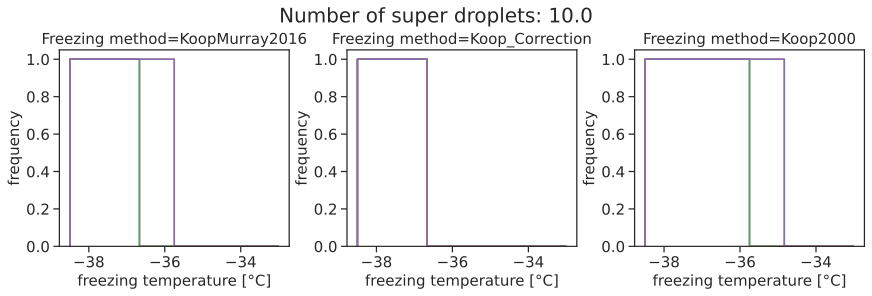

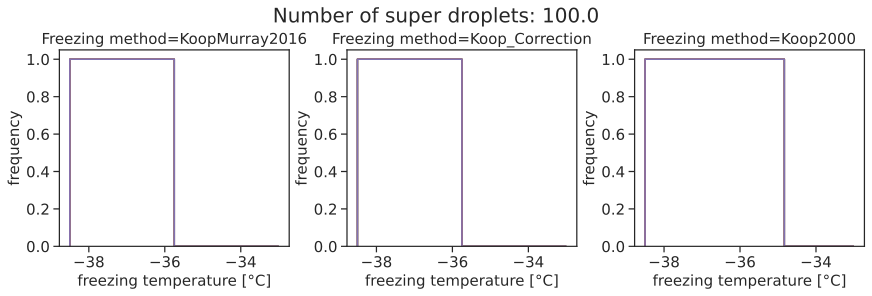

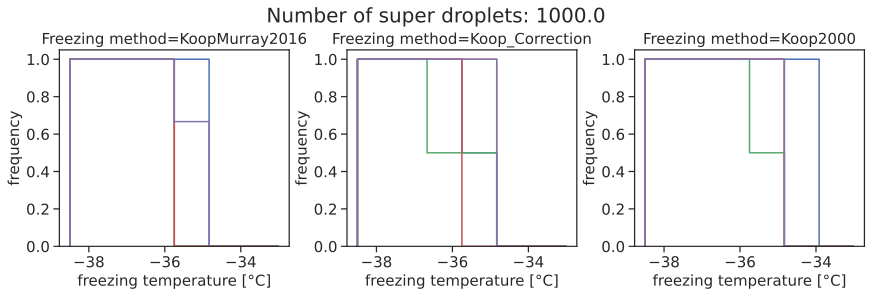

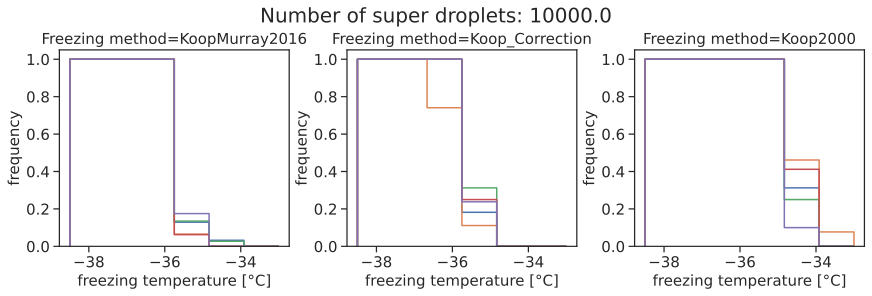

In [8]:
for n_sd in number_of_nsd:
    fig, axs = pyplot.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    fig.suptitle("Number of super droplets: {}".format(n_sd),fontsize=20)
    axs = axs.ravel()
    i = 0
    for simulation in nsd_ensemble_simulations:
        if simulation["settings"]["n_sd"] == n_sd and simulation["settings"]["w_updraft"] == standard["w_updraft"]:
            axs[i] = plot.plot_freezing_temperatures_histogram(axs[i], simulation)
            i += 1
    show_plot()

In [9]:
""" Simulations for updraft histogram  """
simulations_updraft_ensemble = []
vertical_updrafts = np.geomspace(0.1,10,num=10)

for hom_freezing_type in hom_freezing_types:
    for updraft in vertical_updrafts:
        setting_dict = {
            **standard,
            "w_updraft": updraft  * si.meter / si.second,
            "n_sd": int(1e4),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            }

        simulations_updraft_ensemble.append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=0.1 and n_sd=10000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.16681005372000587 and n_sd=10000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.2782559402207124 and n_sd=10000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.46415888336127786 and n_sd=10000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.774263682681127 and n_sd=10000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.291549665014884 and n_sd=10000 and n_dv=4999999999.999999
Starting simulation...
all particle

In [10]:
histogram_data_dict = {}

for hom_freezing_type in hom_freezing_types:

    sub_dict = {}
    histogram_data_dict[hom_freezing_type] = sub_dict

    sub_dict["T_frz_histogram_list"] = []
    sub_dict["w_updraft_histogram_list"] = []

    for i, updraft in enumerate(vertical_updrafts):
        for simulation in simulations_updraft_ensemble:
            if (simulation["settings"]["w_updraft"] == updraft
                    and simulation["settings"]["hom_freezing"] == hom_freezing_type):
                output = simulation["ensemble_member_outputs"][0]
                T_frz = output["T_frz"][-1]
                sub_dict["T_frz_histogram_list"].extend( T_frz )
                sub_dict["w_updraft_histogram_list"].extend( np.full_like(T_frz, updraft) )

plot.plot_freezing_temperatures_2d_histogram_seaborn(histogram_data_dict)
show_plot() # Does need to be inside the plot function?

KeyError: 'hom_freezing_type'

In [20]:
""" Simulations for CCN concentration histogram  """
simulations_ccn_concentration_ensemble = []
number_concentrations = np.geomspace(100,20000,num=10) / si.cm**3

for hom_freezing_type in hom_freezing_types:
    for n_dv in number_concentrations:
        setting_dict = {
            **standard,
            "n_sd": int(1e4),
            "N_dv_droplet_distribution":  n_dv,
            "T0": formulae.trivia.C2K(-30),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            }
        simulations_ccn_concentration_ensemble.append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10000 and n_dv=99999999.99999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10000 and n_dv=180164823.06544116
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10000 and n_dv=324593634.7020169
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10000 and n_dv=584803547.6425728
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10000 and n_dv=1053610276.8906642
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10000 and n_dv=1898235091.1593704
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpd

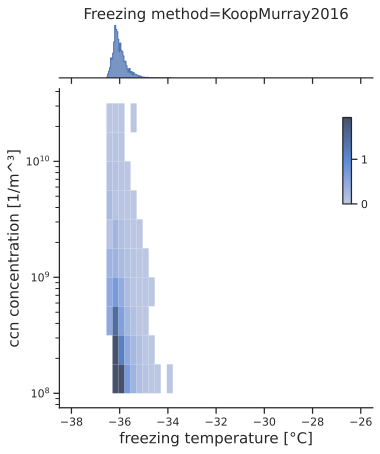

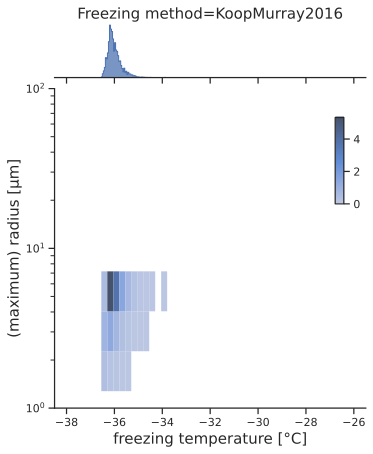

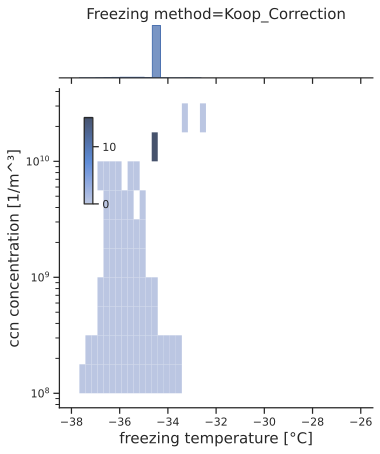

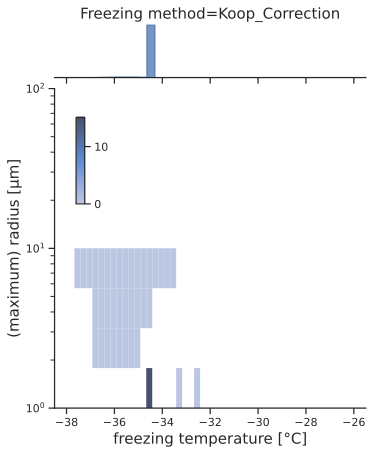

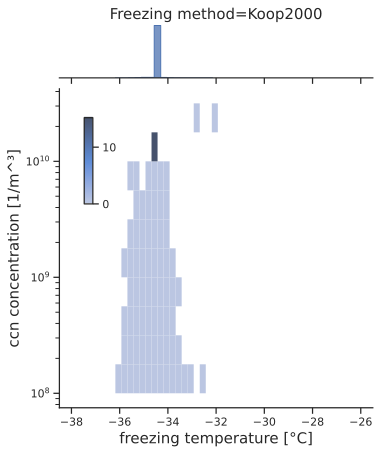

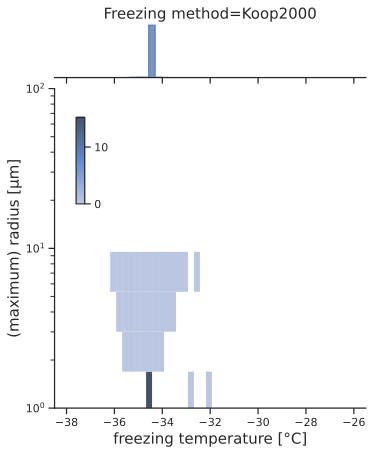

In [21]:
histogram_data_ccn_concentration_ensemble = {}

for hom_freezing_type in hom_freezing_types:

    sub_dict = {}
    histogram_data_ccn_concentration_ensemble[hom_freezing_type] = sub_dict

    sub_dict["T_frz_histogram_list"] = []
    sub_dict["n_ccn_histogram_list"] = []
    sub_dict["rc_max_histogram_list"] = []

    for n_ccn in number_concentrations:
        for simulation in simulations_ccn_concentration_ensemble:
            if (simulation["settings"]["hom_freezing"] == hom_freezing_type
                    and simulation["settings"]["N_dv_droplet_distribution"] == n_ccn):
                output = simulation["ensemble_member_outputs"][0]
                T_frz = np.asarray(output["T_frz"][-1])
                rc = np.asarray(output["rs"])
                sub_dict["T_frz_histogram_list"].extend( T_frz )
                sub_dict["n_ccn_histogram_list"].extend( np.full_like(T_frz, n_ccn) )
                sub_dict["rc_max_histogram_list"].extend( np.full_like(T_frz, np.amax(rc)) )

plot.plot_freezing_temperatures_2d_histogram_seaborn(histogram_data_ccn_concentration_ensemble)
show_plot() # Does need to be inside the plot function?